# 8 Faces Competition

In [46]:
import os
os.environ["KERAS_BACKEND"] = "tensorflow"

%matplotlib inline

import matplotlib.pyplot as plt
import matplotlib.image as imgplot
import numpy as np
from sklearn.metrics import confusion_matrix
from keras.utils.vis_utils import model_to_dot

import time
import tensorflow as tf
tf.set_random_seed(1)

from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout, BatchNormalization
from keras.layers import Convolution2D, MaxPooling2D, Flatten
import keras
import sys
print ("Keras {} TF {} Python {}".format(keras.__version__, tf.__version__, sys.version_info))

Keras 2.1.4 TF 1.2.1 Python sys.version_info(major=3, minor=6, micro=4, releaselevel='final', serial=0)


#### loading data

In [47]:
# Downloading the data, if it does not exist, this will take some time... (>120MB)
import urllib
import os
if not os.path.isfile('8_faces_train_and_valid.hdf5'):
    urllib.request.urlretrieve(
    "https://www.dropbox.com/s/dx03vk6dmbtoywn/8_faces_train_and_valid.hdf5?dl=1",
    "8_faces_train_and_valid.hdf5")

In [48]:
import h5py

h5f_X = h5py.File('8_faces_train_and_valid.hdf5', 'r')
print(list(h5f_X.keys()))
X_train = h5f_X['X_train_8_faces']
print(X_train.shape)
Y_train = h5f_X['Y_train_8_faces']
print(Y_train.shape)
X_valid = h5f_X['X_valid_8_faces']
print(X_valid.shape)
Y_valid = h5f_X['Y_valid_8_faces']
print(Y_valid.shape)

['X_train_8_faces', 'X_valid_8_faces', 'Y_train_8_faces', 'Y_valid_8_faces']
(2000, 48, 48, 3)
(2000,)
(400, 48, 48, 3)
(400,)


#### show random picture

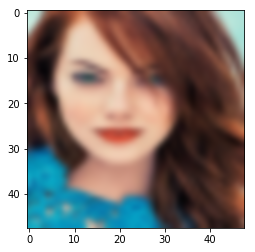

In [49]:
rmd=np.random.randint(0,len(X_train))
plt.imshow(np.asarray(X_train[rmd],dtype="uint8"),interpolation="bicubic")

## data preparation
#### normalization

In [50]:
X_mean = np.mean( X_train, axis = 0)
X_std = np.std( X_train, axis = 0)

X_train = (X_train - X_mean ) / (X_std + 0.0001)
X_valid = (X_valid - X_mean ) / (X_std + 0.0001)

#### one-hot encoding

In [51]:
def convertToOneHot(vector, num_classes=None):
    result = np.zeros((len(vector), num_classes), dtype='int32')
    result[np.arange(len(vector)), vector] = 1
    return result

Y_train=convertToOneHot(Y_train,num_classes=8)
Y_valid=convertToOneHot(Y_valid,num_classes=8)

print(Y_train[13])
print(Y_valid[13])

[0 0 0 0 1 0 0 0]
[0 1 0 0 0 0 0 0]


## Define Network
#### Layers

In [52]:
model = Sequential()
name = 'simple_CNN_dropout'

# Convolutional Part
model.add(Convolution2D(8, (3,3), input_shape=(48, 48, 3)))
model.add(BatchNormalization())
model.add(Activation("relu"))

model.add(Convolution2D(8, (3,3)))
model.add(BatchNormalization())
model.add(Activation("relu"))

model.add(MaxPooling2D((2,2), 2))

model.add(Convolution2D(16, (3,3)))
model.add(BatchNormalization())
model.add(Activation("relu"))

model.add(Convolution2D(16, (3,3)))
model.add(BatchNormalization())
model.add(Activation("relu"))

model.add(MaxPooling2D((2,2), 2))

# Dense Part
model.add(Flatten())
model.add(Dense(80))
model.add(Dropout(0.5))
model.add(BatchNormalization())
model.add(Activation("relu"))

# Output Layer
model.add(Dense(8))
model.add(Activation("softmax"))

model.compile(loss="categorical_crossentropy",
              optimizer="adam",
              metrics=["accuracy"])
            

#### Summary

In [53]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_14 (Conv2D)           (None, 46, 46, 8)         224       
_________________________________________________________________
batch_normalization_11 (Batc (None, 46, 46, 8)         32        
_________________________________________________________________
activation_19 (Activation)   (None, 46, 46, 8)         0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 44, 44, 8)         584       
_________________________________________________________________
batch_normalization_12 (Batc (None, 44, 44, 8)         32        
_________________________________________________________________
activation_20 (Activation)   (None, 44, 44, 8)         0         
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 22, 22, 8)         0         
__________

## Training

In [54]:
tensorboard = keras.callbacks.TensorBoard(
        log_dir='tensorboard/faces/' + name + '/', 
        write_graph=True,
        histogram_freq=0)

In [55]:
#save model after every 10 epochs 
savedir = "Checkpoints/8_faces/"+name+"/"
os.makedirs(savedir,exist_ok=True)       
checkpointer = keras.callbacks.ModelCheckpoint( 
        filepath =  savedir+name+"weights_epoch_{epoch:03d}-{val_loss:.2f}.hdf5",
        verbose = 1, 
        save_best_only = False,
        period = 10 )

In [ ]:
history=model.fit(X_train, Y_train,
                  batch_size=128,
                  epochs=30,
                  verbose=2,
                  validation_data=(X_valid, Y_valid),
                  callbacks=[tensorboard, checkpointer])

Train on 2000 samples, validate on 400 samples
Epoch 1/30
 - 11s - loss: 2.1876 - acc: 0.2030 - val_loss: 1.8857 - val_acc: 0.3250
Epoch 2/30
 - 11s - loss: 1.7806 - acc: 0.3455 - val_loss: 1.7005 - val_acc: 0.3975
Epoch 3/30
 - 11s - loss: 1.6009 - acc: 0.4215 - val_loss: 1.6114 - val_acc: 0.4500
Epoch 4/30
 - 11s - loss: 1.4359 - acc: 0.4920 - val_loss: 1.5527 - val_acc: 0.4875
Epoch 5/30
 - 11s - loss: 1.3012 - acc: 0.5525 - val_loss: 1.4913 - val_acc: 0.5025
Epoch 6/30
 - 11s - loss: 1.1712 - acc: 0.5955 - val_loss: 1.5479 - val_acc: 0.4425
Epoch 7/30
 - 11s - loss: 1.0813 - acc: 0.6435 - val_loss: 1.4809 - val_acc: 0.4625
Epoch 8/30
 - 11s - loss: 0.9836 - acc: 0.6945 - val_loss: 1.3888 - val_acc: 0.5525
Epoch 9/30
 - 11s - loss: 0.9034 - acc: 0.7265 - val_loss: 1.4036 - val_acc: 0.4975
Epoch 10/30
 - 11s - loss: 0.8357 - acc: 0.7510 - val_loss: 1.3282 - val_acc: 0.5675

Epoch 00010: saving model to Checkpoints/8_faces/simple_CNN_dropout/simple_CNN_dropoutweights_epoch_010-1.33.hd

## Evaluation
#### History

In [ ]:
plt.plot(history.history["acc"])
plt.plot(history.history["val_acc"])
plt.title("model accuracy")
plt.ylabel("accuracy")
plt.xlabel("Epoch")
plt.legend(["train", "valid"], loc="lower right")
plt.show()

plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.title("model loss")
plt.ylabel("loss")
plt.xlabel("Epoch")
plt.legend(["train", "valid"], loc="lower right")
plt.show()

In [39]:
del model